#  <center> <span style="color:black"> Модель для прогнозирования оттока клиентов для сервиса доставки кофе </span> </center>

Нам нужно построить модель бинарной классификации, которая спрогнозирует вероятность оттока каждого клиента в следующем месяце. 
Для решения задачи нам доступен датасет `coffee_churn_dataset.csv`:

- `user_id` — идентификатор пользователя.
- `days_since_last_order` — количество дней, прошедших с последнего заказа.
- `order_frequency_month` — среднее число заказов в месяц.
- `order_frequency_week` — среднее число заказов в неделю.
- `avg_order_value` — средний чек, в рублях.
- `median_order_value` — медианный чек, в рублях.
- `total_spent_last_month` — сумма заказов за последний месяц.
- `total_spent_last_week` — сумма заказов за последнюю неделю.
- `discount_usage_rate` — доля заказов со скидкой за последний месяц.
- `last_coffee_type` — сорт кофе, купленный пользователем в последний раз на момент сбора данных.
- `preferred_roast` — предпочитаемый тип обжарки.
- `milk_preference` — предпочитаемый тип молока.
- `seasonal_menu_tried` — отметка о том, пробовал ли пользователь новейшее сезонное меню.
- `coffee_bean_origin` — страна происхождения зерна.
- `last_drink_size` — размер последнего напитка, купленного на момент сбора данных.
- `subscription_status` — тип подписки пользователя.
- `app_opens_per_week` — сколько раз за неделю пользователь в среднем открывал приложение доставки кофе.
- `notifications_enabled` — включены ли у пользователя уведомления.
- `review_rating_last_10` — средняя оценка последних на момент сбора данных десяти заказов клиента.
- `review_rating_last_1` — оценка последнего на момент сбора данных заказа клиента.
- `app_crashes_last_month` — сколько раз приложение зависало за последний месяц.
- `seasons` — текущее время года.
- `days_since_last_promo` — сколько дней прошло с последнего использования акции или промокода.
- `phone_type` — тип устройства, с которого пользователь чаще всего совершал покупки.
- `coffee_preference_change` — менялись ли вкусовые предпочтения пользователя.
- `geo_location` — идентификатор региона пользователя.
- `churn` — перестал ли пользователь пользоваться сервисом.

# <center> <span style="color:black"> Содержание </span> </center>

## <center> <span style="color:black"> Этап 1. Подготовка среды и библиотек, знакомство с данными </span> </center>
Загружаем необходимые для работы библиотеки, фиксируем random state для воспроизводимости результатов, после чего выводим датасет и основную информацию о нем, чтобы ознакомится с данными.

In [ ]:
!pip install category_encoders

!pip install phik

!pip install --upgrade scikit-learn

In [1]:
# Импортируем нужные библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import category_encoders
import joblib
from phik import phik_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Фиксируем random_state

RANDOM_STATE = 42

In [2]:
# Выгружаем данные в датафрейм из датасета coffee_churn_dataset.csv

try:
    df = pd.read_csv (r'coffee_churn_dataset.csv',sep = ',', decimal = '.')
except:
    df = pd.read_csv ('/datasets/coffee_churn_dataset.csv',sep = ',', decimal = '.')

# Ознакомимся с датасетом, а также выведем основную информацию о нем
pd.set_option('display.max_columns', None)
df.sample(5)

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,preferred_roast,milk_preference,seasonal_menu_tried,coffee_bean_origin,last_drink_size,subscription_status,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
2483,user_01790,0.0,7.544841,1.779267,1768.661451,544.119793,3969.038428,NaN,0.039075,arabica,dark,whole,1.0,vietnam,medium,pro,17.859373,0.0,4.422190,0.936500,3.0,spring,30.0,android,0.0,geo_74,0
4965,user_08497,4.0,3.705301,NaN,619.407628,NaN,793.832120,275.497639,0.381015,arabica,light,whole,1.0,ethiopia,medium,NaN,13.718557,1.0,4.758163,6.215540,2.0,spring,17.0,ios,0.0,geo_1,0
8090,user_06075,0.0,1.606660,0.449380,619.354463,308.643363,455.720665,164.973719,0.342447,NaN,dark,whole,1.0,brazil,large,none,4.303786,1.0,4.367436,4.753072,1.0,summer,NaN,ios,0.0,geo_69,0
1470,user_07907,7.0,0.903042,NaN,1127.412825,692.761909,537.505813,NaN,0.178088,blend,medium,whole,1.0,guatemala,medium,none,11.475581,1.0,2.384445,5.625940,1.0,autumn,1.0,ios,0.0,geo_25,0
5708,user_09060,12.0,1.273113,0.180760,864.170245,361.827448,377.516912,63.992993,0.107515,robusta,medium,oat,1.0,vietnam,small,pro,6.749393,1.0,4.786111,5.717431,0.0,summer,NaN,ios,0.0,geo_77,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

In [4]:
df.describe(include = 'all')

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,preferred_roast,milk_preference,seasonal_menu_tried,coffee_bean_origin,last_drink_size,subscription_status,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
count,10450,9505.000000,9850.000000,10062.000000,9867.000000,9619.000000,10156.000000,9506.000000,10053.000000,10192,10334,9782,9461.000000,9768,9946,9512,9554.000000,9913.000000,9757.000000,9593.000000,9729.000000,9771,9719.000000,10114,9840.000000,10340,10450.000000
unique,10450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,6,NaN,6,3,4,NaN,NaN,NaN,NaN,NaN,4,NaN,3,NaN,100,NaN
top,user_00318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,arabica,medium,whole,NaN,ethiopia,medium,none,NaN,NaN,NaN,NaN,NaN,spring,NaN,android,NaN,geo_2,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6134,3458,2876,NaN,1690,4925,3803,NaN,NaN,NaN,NaN,NaN,2507,NaN,4611,NaN,1629,NaN
mean,NaN,4.394214,4.025666,0.930686,1063.741207,452.651500,1946.132979,413.004760,0.284446,NaN,NaN,NaN,0.701194,NaN,NaN,NaN,11.330895,0.753052,4.206709,4.022460,1.013362,NaN,14.554584,NaN,0.192480,NaN,0.060191
std,NaN,4.858757,2.826144,0.657261,707.713396,258.657571,2370.619590,445.634902,0.158735,NaN,NaN,NaN,0.457759,NaN,NaN,NaN,14.528887,0.431258,0.782212,1.207883,1.010342,NaN,15.308869,NaN,0.394268,NaN,0.237852
min,NaN,0.000000,0.011046,-0.169131,-32.075932,-10.353340,-43.716463,-2290.559468,0.002162,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,1.415526,-0.897000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
25%,NaN,1.000000,1.937767,0.445185,552.898663,262.908598,629.680382,136.565833,0.159884,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,6.313628,1.000000,3.675543,3.214157,0.000000,NaN,4.000000,NaN,0.000000,NaN,0.000000
50%,NaN,3.000000,3.381094,0.784839,898.643524,406.456818,1300.409757,288.277327,0.264583,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,9.228383,1.000000,4.203555,3.990032,1.000000,NaN,10.000000,NaN,0.000000,NaN,0.000000
75%,NaN,6.000000,5.439363,1.262350,1406.332153,590.418070,2481.650495,549.699420,0.387056,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,12.726649,1.000000,4.717292,4.845225,2.000000,NaN,20.000000,NaN,0.000000,NaN,0.000000


In [5]:
# Cоздаем копию датасета до преобразования для возможности проверить сделанные изменения после предобработки
temp = df.copy() 

## <center> <span style="color:black"> Этап 2. Исследовательский анализ данных </span> </center>

Для реализации задачи бинарной классификации мы будем использовать датасет `coffee_churn_dataset.csv`. В нем собраны все необходимые для моделирования, признаки по каждому клиенту за последние 4 недели. Они представлены в виде готовой аналитической витрины с посчитанными мерами центральной тенденции: средними, медианами и т.д. В данных содержатся как числовые признаки, так и категориальные, охватывающие ряд предпочтений пользователей, такие как: предпочитаемый тип обжарки, предпочитаемый тип молока и т.д. В датасете `10450` строк и `27` столбцов, включая целевую переменную. 
При первом рассмотрении данные подготовлены достаточно хорошо, типы данных соответствуют значениям. Все дальнейшие решения мы будем принимать на основе исследовательского анализа.

Приступаем к исследовательскому анализу.

 <center> <span style="color:black"> 1. Целевая переменная </span> </center>
Начнем с целевой переменной. Посмотрим на особенности ее распределения, есть ли дисбаланс в данных.

Ушедшие клиенты = 629
Оставшиеся клиенты = 9821
Доля положительного класса = 0.060191387559808615


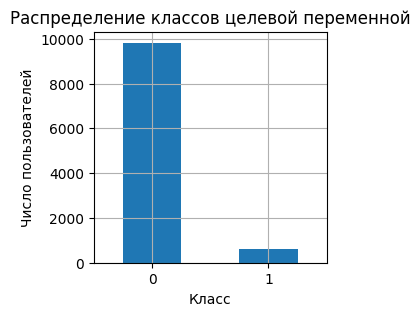

In [6]:
# Выведем колчество положительных и отрицательных классов и визуализируем их в виде диаграммы

pos_class = df ['churn'].sum()
neg_class = df ['churn'].count() - pos_class
rat_pos_class = (pos_class / df ['churn'].count())

print (f'Ушедшие клиенты = {pos_class}')
print (f'Оставшиеся клиенты = {neg_class}')
print (f'Доля положительного класса = {rat_pos_class}')

df ['churn'].value_counts().plot (kind = 'bar',
                   rot = 0,
                   figsize = (3, 3))

plt.title ('Распределение классов целевой переменной')
plt.xlabel ('Класс')
plt.ylabel ('Число пользователей')
plt.grid()

plt.show()

Наблюдается сильный дисбаланс классов. Большинство пользователей остается на сервисе и лишь `629` клиентов за период сбора данных перестало им пользоваться. В связи с этим, на этапе разделения данных по выборкам будем использовать стратификацию, для сохранения пропорций.

<center> <span style="color:black"> 2. Признаки </span> </center>
В нашем датасете присутствует достаточно большое число разнообразных признаков описывающих поведение и предпочтения пользователей. Некоторые из них выглядят избыточными или потенциально бесполезными для анализа вероятности ухода клиента (churn). Это:

- `user_id` - идентификаторы пользователей не несут смысловой нагрузки для моделирования. Их лучше исключить;
- `seasons` - данный признак предполагает текущее время года, но по данным заказчика датасет агрегирован за последние 4 недели, без указания конкретных особенностей. Мы не знаем были ли разные периоды сбора данных для разных клиентов: для user_00931 данные собирались осенью, для user_03219 — весной, или же это ошибка! Следовательно, данный признак избыточен и может привести к логической противоречивости. Лучше удалить данный признак, чтобы избежать ошибок в обучении модели;
- `geo_location` - избыточный признак, несущий огромное число уникальных значений, перегружает данные.
Дальнейшие решения по признакам мы будем принимать после проверки их корреляции друг с другом, дабы избежать мультиколлинеарности, а также после первого обучения модели, исходя из весов коэфициентов.

Удалим данные признаки после проверки датасета на дубликаты.

<center> <span style="color:black"> 2. Дубликаты и пропуски </span> </center>

Проверим датасет на наличие дубликатов и пропусков.
Для начала посмотрим на наличие явных и неявных дубликатов.

In [7]:
#Смотрим на кол-во явных и не явных дубликатов в датасете

explict = df.duplicated().sum()
not_explict_reg_n = df.duplicated(subset=['user_id']).sum()

print (f'Количество явных дубликатов: {explict}')
print (f'Количество дубликатов по ID: {not_explict_reg_n}')

Количество явных дубликатов: 0
Количество дубликатов по ID: 0


Дубликатов в данных нет. Удалим не нужные нам столбцы `user_id`, `geo_location` и `seasons`. 

In [8]:
#Удаляем столбец user_id

df = df.drop (columns = ['user_id', 'seasons', 'geo_location'], axis = 1)

Посмотрим на количество и долю пропусков. Из info видно, что пропуски в том, или ином количестве содержатся практически во всех столбцах датасета. Кроме того, выведим количество и долю пропусков в строках с положительным классом, чтобы иметь представление о их распределении между классами целевой переменной.

In [9]:
#Выведим количество и долю пропусков в столбцах нашего датасета

missing_data = []
for column in df.columns:
    missing_count = df [column].isna().sum()
    ratio_missing = df [column].isna().mean() * 100
    missing_count_class_1 = df [df ['churn'] == 1][column].isna().sum()
    ratio_missing_class_1 = df [df ['churn'] == 1][column].isna().mean() * 100
    if missing_count > 0:
        missing_data.append ((column, missing_count, round (ratio_missing, 2,), missing_count_class_1, round (ratio_missing_class_1, 2)))

sorted_missing_data = sorted (missing_data, key = lambda x: x[1])

for name, count, ratio, count_1, ratio_1 in sorted_missing_data:
    print (f'Количество пропусков в столбце {name}: {count} \n Доля пропусков: {ratio} \n Количество пропусков и их доля с положительным классом: {count_1} ({ratio_1})')

Количество пропусков в столбце preferred_roast: 116 
 Доля пропусков: 1.11 
 Количество пропусков и их доля с положительным классом: 4 (0.64)
Количество пропусков в столбце last_coffee_type: 258 
 Доля пропусков: 2.47 
 Количество пропусков и их доля с положительным классом: 18 (2.86)
Количество пропусков в столбце total_spent_last_month: 294 
 Доля пропусков: 2.81 
 Количество пропусков и их доля с положительным классом: 22 (3.5)
Количество пропусков в столбце phone_type: 336 
 Доля пропусков: 3.22 
 Количество пропусков и их доля с положительным классом: 12 (1.91)
Количество пропусков в столбце order_frequency_week: 388 
 Доля пропусков: 3.71 
 Количество пропусков и их доля с положительным классом: 21 (3.34)
Количество пропусков в столбце discount_usage_rate: 397 
 Доля пропусков: 3.8 
 Количество пропусков и их доля с положительным классом: 29 (4.61)
Количество пропусков в столбце last_drink_size: 504 
 Доля пропусков: 4.82 
 Количество пропусков и их доля с положительным классом: 

Пропуски присутствуют практически во всех столбцах датасета, захватывая строки обоих классов. При этом количество их и доля сильно разница, максимальное кол-во пропусков в столбце `seasonal_menu_tried` - `9.46`, а минимальное в `preferred_roast` - `1.11`. В нашем случае, удаление пропущеных значений нежелательно, т.к. в данных наблюдается сильный дисбаланс классов: `629` ушедших клиентов против `9821` оставшихся, и удаление пропусков может усугубить его. Поэтому, мы обработаем пропуски - числовые колонки мы заполним мерами центральной тенденции медианой, или средним, в зависимости от разброса значений, а категориальные - модой, или индикатором `missing`. 

Окончательные решения по стратегиям заполнения пропусков мы примем после исследования выбросов.

<center> <span style="color:black"> 3. Категориальные признаки </span> </center>

Сначала посмотрим на количество уникальных значений в столбцах категориальных признаков и проверим на корректность и необходимость их нормализации.

In [10]:
# Посмотрим на кол-во в номинальных колонках

for column in ['last_coffee_type', 'preferred_roast', 'milk_preference', 'coffee_bean_origin', 'last_drink_size', 'subscription_status', 'phone_type']:
    print(f'Количество уникальных значений в столбце {column}: {df [column].nunique()}')
    print()    

Количество уникальных значений в столбце last_coffee_type: 3

Количество уникальных значений в столбце preferred_roast: 3

Количество уникальных значений в столбце milk_preference: 6

Количество уникальных значений в столбце coffee_bean_origin: 6

Количество уникальных значений в столбце last_drink_size: 3

Количество уникальных значений в столбце subscription_status: 4

Количество уникальных значений в столбце phone_type: 3



In [11]:
#Посмотрим на корректность уникальных значений в категориальных столбцах
for column in ['last_coffee_type', 'preferred_roast', 'milk_preference', 'coffee_bean_origin', 'last_drink_size', 'subscription_status', 'phone_type']:
    print(f"\nColumn: {column}")
    print("Unique values:", df[column].unique())
    print("Missing values count:", df[column].isna().sum())
    print("Value counts:")
    print(df[column].value_counts(dropna=False), "\n")


Column: last_coffee_type
Unique values: ['blend' 'arabica' 'robusta' nan]
Missing values count: 258
Value counts:
last_coffee_type
arabica    6134
robusta    2524
blend      1534
NaN         258
Name: count, dtype: int64 


Column: preferred_roast
Unique values: ['light' 'medium' 'dark' nan]
Missing values count: 116
Value counts:
preferred_roast
medium    3458
light     3453
dark      3423
NaN        116
Name: count, dtype: int64 


Column: milk_preference
Unique values: ['almond' 'whole' 'oat' 'skim' 'soy' nan 'none']
Missing values count: 668
Value counts:
milk_preference
whole     2876
oat       1982
almond    1483
skim      1451
none      1015
soy        975
NaN        668
Name: count, dtype: int64 


Column: coffee_bean_origin
Unique values: ['vietnam' 'guatemala' 'brazil' 'colombia' 'kenya' nan 'ethiopia']
Missing values count: 682
Value counts:
coffee_bean_origin
ethiopia     1690
kenya        1646
vietnam      1635
guatemala    1621
brazil       1596
colombia     1580
NaN    

В датасете содержится достаточно много категориальных признаков. Среди них есть бинарные, которые представлены в числовом формате и не требуют кодировки (seasonal_menu_tried, notifications_enabled, coffee_preference_change), а также номинальные и порядковые, представленные в строковом виде: 
- `last_coffee_type` — сорт кофе, купленный пользователем в последний раз на момент сбора данных,
- `preferred_roast` — предпочитаемый тип обжарки,
- `milk_preference` — предпочитаемый тип молока,
- `coffee_bean_origin` — страна происхождения зерна,
- `last_drink_size` — размер последнего напитка, купленного на момент сбора данных,
- `subscription_status` — тип подписки пользователя,
- `phone_type` — тип устройства, с которого пользователь чаще всего совершал покупки.


Логистическая регрессия работает только с числовыми признаками, поэтому все перечисленые категориальные признаки формата object необходимо правильным образом закодировать. Т.к. все признаки несут небольшое количество уникальных значений, используем One Hot Encoder для номинальных категорий, а для `subscription_status` и `last_drink_size` - эти признаки являются порядковыми - `OrdinalEncoder`.

Все признаки, описывающие предпочтения клиента, тип подписки и т.д. могут так или иначе влиять на отток клиентов, учитывая наличие в сервисе тех или иных сортов кофе, повышеный сезонный спрос, или регион. Далее в анализе мы посмотрим на корреляционную матрицу признаков и проверим их на наличие мультиколлинеарности. Если какие то признаки будут сильно коррелировать друг с другом, оставим только один из них.

<center> <span style="color:black"> 4. Выбросы </span> </center>

In [12]:
#Выведем основные статистики для числовых колонок

df.describe ()

,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,seasonal_menu_tried,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,days_since_last_promo,coffee_preference_change,churn
count,9505.000000,9850.000000,10062.000000,9867.000000,9619.000000,10156.000000,9506.000000,10053.000000,9461.000000,9554.000000,9913.000000,9757.000000,9593.000000,9729.000000,9719.000000,9840.000000,10450.000000
mean,4.394214,4.025666,0.930686,1063.741207,452.651500,1946.132979,413.004760,0.284446,0.701194,11.330895,0.753052,4.206709,4.022460,1.013362,14.554584,0.192480,0.060191
std,4.858757,2.826144,0.657261,707.713396,258.657571,2370.619590,445.634902,0.158735,0.457759,14.528887,0.431258,0.782212,1.207883,1.010342,15.308869,0.394268,0.237852
min,0.000000,0.011046,-0.169131,-32.075932,-10.353340,-43.716463,-2290.559468,0.002162,0.000000,0.000000,0.000000,1.415526,-0.897000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.937767,0.445185,552.898663,262.908598,629.680382,136.565833,0.159884,0.000000,6.313628,1.000000,3.675543,3.214157,0.000000,4.000000,0.000000,0.000000
50%,3.000000,3.381094,0.784839,898.643524,406.456818,1300.409757,288.277327,0.264583,1.000000,9.228383,1.000000,4.203555,3.990032,1.000000,10.000000,0.000000,0.000000
75%,6.000000,5.439363,1.262350,1406.332153,590.418070,2481.650495,549.699420,0.387056,1.000000,12.726649,1.000000,4.717292,4.845225,2.000000,20.000000,0.000000,0.000000
max,40.000000,27.389318,6.302624,5901.965278,2189.101644,79298.849570,8615.988952,0.887301,1.000000,224.587876,1.000000,7.384425,8.558443,7.000000,140.000000,1.000000,1.000000


Далее посмотрим на распределение значений каждого из числовых признаков. Для этого построим `гистограммы` и `boxplot` для числовых признаков в датасете.

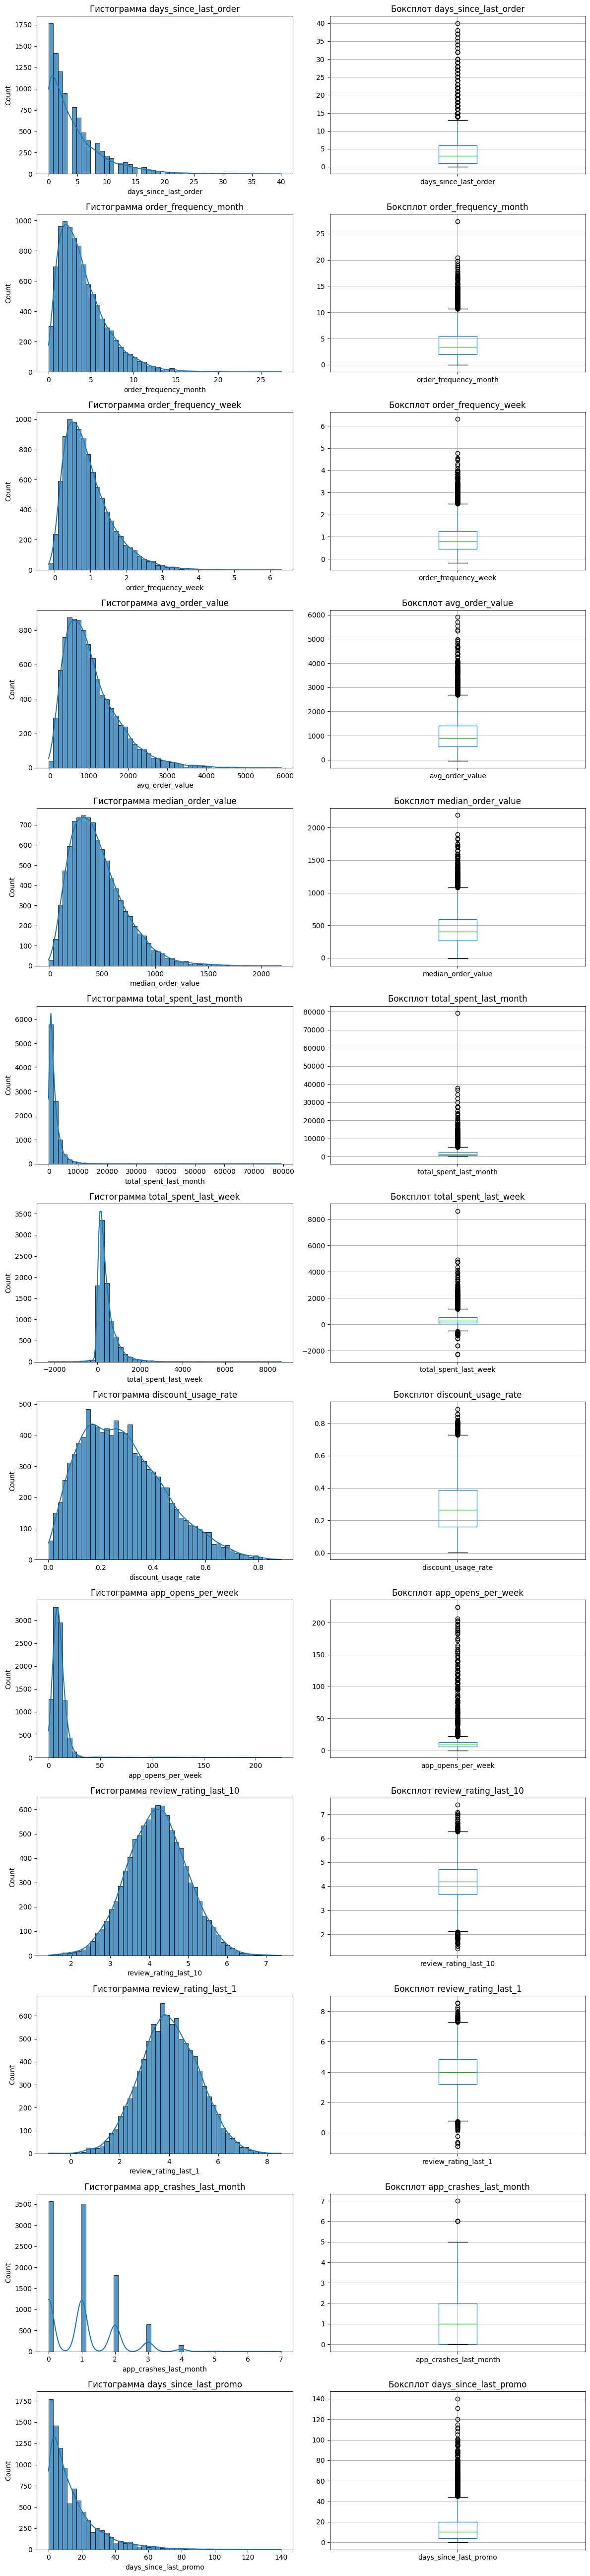

In [13]:
#Получаем список признаков

features = ['days_since_last_order', 'order_frequency_month', 'order_frequency_week', 'avg_order_value', 'median_order_value', 'total_spent_last_month', 
            'total_spent_last_week', 'discount_usage_rate', 'app_opens_per_week', 'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month',
            'days_since_last_promo']
n_features = len(features)

# Подсчет необходимого количества строк 
rows = n_features  # Одна строка для каждого признака
cols = 2           # Два столбца: гистограмма и боксплот

plt.figure(figsize=(12, rows * 4))  

for idx, feature in enumerate(features):
     # Рисуем гистограмму с KDE в левом столбце
    plt.subplot(rows, cols, idx * 2 + 1)
    sns.histplot(df[feature], bins=50, alpha = 0.75, kde=True)
    plt.title(f'Гистограмма {feature}')

    # Рисуем боксплот в правом столбце
    plt.subplot(rows, cols, idx * 2 + 2)
    df.boxplot(column= feature, vert=True)  
    plt.title(f'Боксплот {feature}')

plt.tight_layout()
plt.show()

Сразу построим диаграмму сравнения боксплотов, для визуализации разницы масштабов признаков.

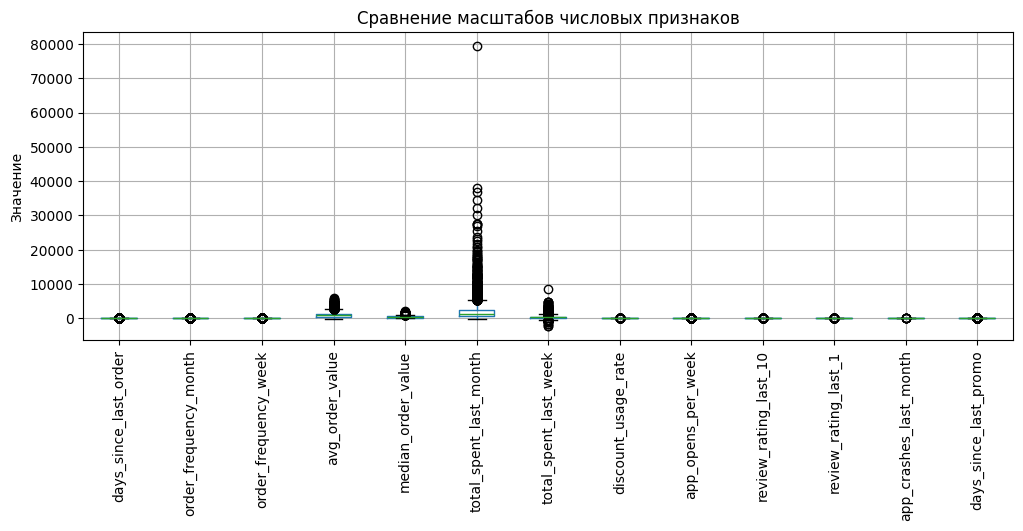

In [14]:
#Визуализируем масштаб данных

plt.figure (figsize= (12, 4))

# Строим boxplot (диаграмму размаха) для всех признаков

df.boxplot (column = features, rot = 90)

plt.title ('Сравнение масштабов числовых признаков')
plt.ylabel ('Значение')

plt.show ()

Мы видим, что во всех без исключения числовых колонках датасета присутствуют выбросы, что в той, или иной степени отражается на распределении значений. Нормальное распределение сохраняется у признаков `review_rating_last_10` и `review_rating_last_1`. `discount_usage_rate`, также, имеет хорошее распределение, незначительно смещенное вправо. Остальные признаки имеют явную ассиметрию, как правило правую и содержат в себе разное количество экстремальных значений. Исходя из специфики поставленной перед нами задачи и данных, выбросы `возможны` и несут важную информацию для модели классификации, поэтому фильтровать и удалять их мы не будем, чтобы не сместить баланс классов в данных и избежать возможных в дальнейшем ошибок обучения. Мы будем использовать масштабирование, чтобы избавится от огромного разброса значений, а также попробуем улучшить качество обучения через преобразование некоторых, наиболее дисбалансных признаков.

Кроме этого, в некоторых столбцах заметны явные ошибки. Например, `отрицательные значения` в столбце `review_rating_last_1`. Рейтинг не может быть отрицательным, поэтому данную ошибку необходимо устранить. Т.к. удаление строк в нашем случае нежелательно, заменим отрицательные значения данного признака на `0`. 

Отрицательные значения присутствуют также в колонках `order_frequency_week, avg_order_value, median_order_value, total_spent_last_month и total_spent_last_week`, но в данном контексте такое может быть, если учитывать возможность возврата заказа и возвращения средств клиенту. Но, т.к. заказчик не уточняет данный вопрос, мы подробнее проанализируем эти признаки, посмотрим на количество отрицательных значений и примем решение. 

Подозрительное распределение значений присутствует в признаке `app_opens_per_week`. При `max=224.59`  `75-ый процентиль` равен `12.73`. Это может указывать на ошибку в данных, или работу ботов. К сожалению у нас нет возможности проверить достоверность этих предположений. Оставим признак как есть, но попробуем сгладить его квадратным корнем на этапе тестирования.

In [15]:
# Признаки с отрицательными значениями
negative_check_cols = [
    'order_frequency_week', 
    'avg_order_value', 
    'median_order_value',
    'total_spent_last_month', 
    'total_spent_last_week'
]

# Проверяем отрицательные значения
negative_stats = {}
for col in negative_check_cols:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        neg_percent = (neg_count / len(df)) * 100
        negative_stats[col] = {
            'count': neg_count,
            'percent': neg_percent,
            'min': df[col].min(),
            'max': df[col].max()
        }

negative_df = pd.DataFrame(negative_stats).T
print("Статистика отрицательных значений:")
print(negative_df)

Статистика отрицательных значений:
                        count   percent          min           max
order_frequency_week     83.0  0.794258    -0.169131      6.302624
avg_order_value           2.0  0.019139   -32.075932   5901.965278
median_order_value        2.0  0.019139   -10.353340   2189.101644
total_spent_last_month    2.0  0.019139   -43.716463  79298.849570
total_spent_last_week   171.0  1.636364 -2290.559468   8615.988952


Мы видим, что в `order_frequency_week` отрицательные значения очень маленькие, это скорее всего ошибка, или неправильное округление. Заменим в этом признаке их на `0`.
Признаки `avg_order_value, median_order_value, total_spent_last_month` содержат чрезвычайное маленькое кол-во отрицательных строк, всего по 2 на признак, также заменим на `0`.

`total_spent_last_week` в нашем случае самый проблемный. Помимо количества и доли - `171` и `1.6%`, он несет достаточно большие значения `-2290`, которые могут повлиять на обучение модели. Учитывая, что вся информация данного признака уже учтена в `total_spent_last_month`, удалим его.

In [16]:
# Заменим отрицательные значения на 0
def fill_0 (column):
    df [column] = np.where (df [column] < 0, 0, df [column])
    return df [column]
columns = ['order_frequency_week', 'avg_order_value', 'median_order_value', 'total_spent_last_month', 'review_rating_last_1']
for column in columns:
    df [column] = fill_0 (column)

# Удалим total_spent_last_week

df = df.drop (columns = ['total_spent_last_week'])

<center> <span style="color:black"> 4. Корреляции между признаками </span> </center>

Теперь проверим корреляции признаков друг с другом. Для этого построим корреляционную матрицу.

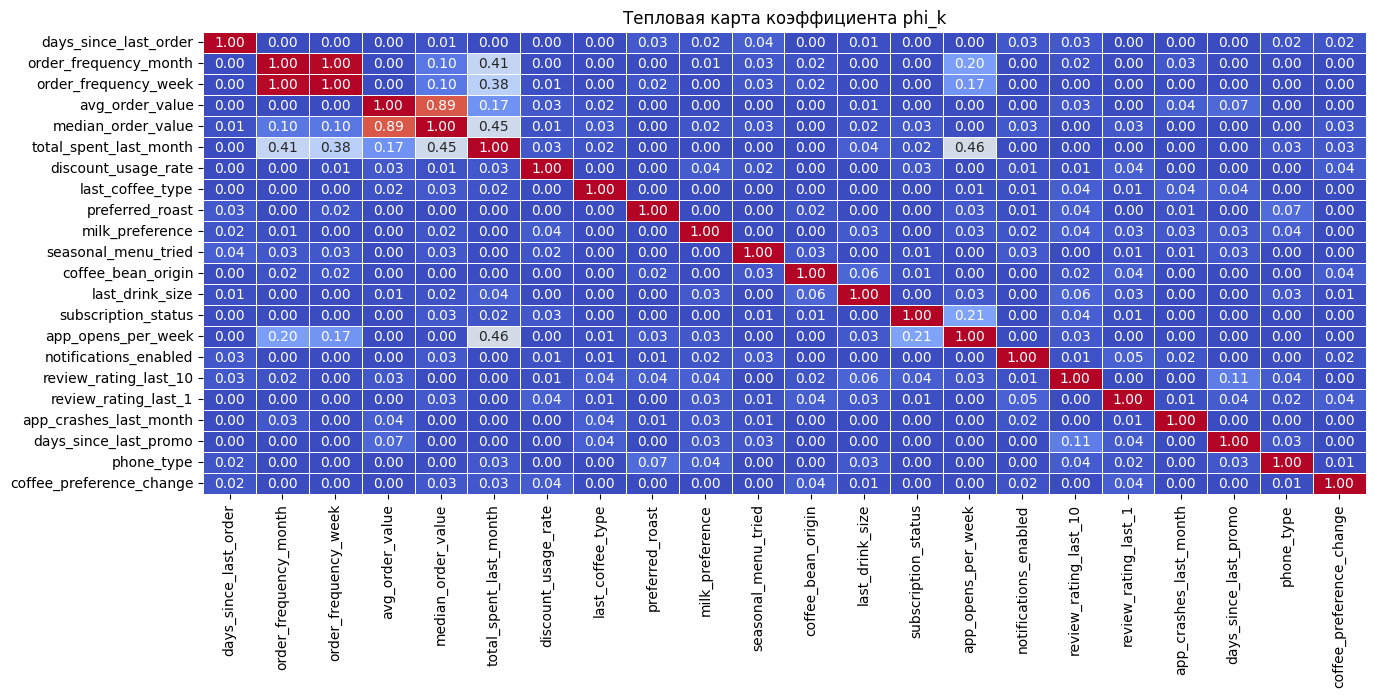

In [17]:
#Строим корреляционную матрицу

correlation_matrix = df.phik_matrix (interval_cols = ['days_since_last_order', 'order_frequency_month', 'order_frequency_week', 'avg_order_value', 'median_order_value', 'total_spent_last_month', 
            'discount_usage_rate', 'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month', 'app_opens_per_week',
            'days_since_last_promo'])

#Для наглядности построим тепловую карту на основе нашей матрицы
plt.figure (figsize= (15, 6))
data_heatmap = correlation_matrix.drop(index='churn', columns='churn')

sns.heatmap (
    data_heatmap,
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm',  
    linewidths=0.5, 
    cbar=False
)
plt.title ('Тепловая карта коэффициента phi_k')
plt.show ()

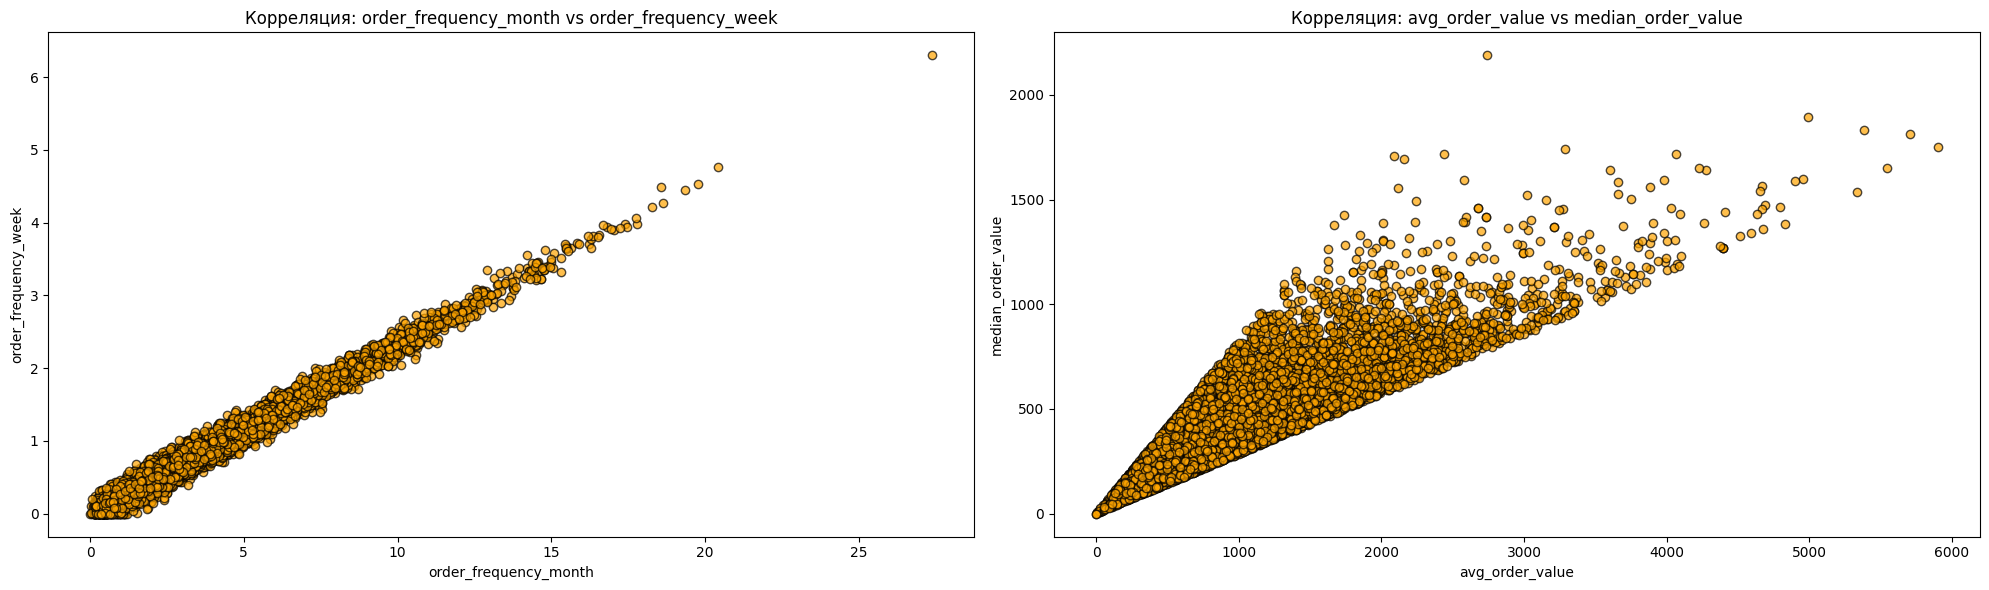

In [18]:
#Визуализируем сильные коррелции между признаками

plt.figure (figsize=(20, 6))
plt.subplot (1, 2, 1)
plt.scatter (x=df['order_frequency_month'], 
            y=df['order_frequency_week'],
            alpha=0.7,
            color='orange',
            edgecolor='k')
plt.xlabel('order_frequency_month')
plt.ylabel('order_frequency_week')
plt.title(f'Корреляция: order_frequency_month vs order_frequency_week')

plt.subplot (1, 2, 2)
plt.scatter (x=df['avg_order_value'], 
            y=df['median_order_value'],
            alpha=0.7,
            color='orange',
            edgecolor='k')
plt.xlabel('avg_order_value')
plt.ylabel('median_order_value')
plt.title(f'Корреляция: avg_order_value vs median_order_value')

plt.tight_layout()
plt.show ()

Среди признаков есть некоторые с выраженной корреляцией. Самые большие значения имеют пары: `order_frequency_month x order_frequency_week`, `avg_order_value x median_order_value`. Первая пара коррелирует очень сильно, оба показателя отражают идентичную информацию о частоте покупок, поэтому наличие обоих признаков одновременно может привести к избыточности и мультиколлинеарности. Чтобы избежать возможной нестабильности коэффициентов, оставим только один признак по среднему кол-ву заказов: `order_frequency_month`. Похожая ситуация с признаками меры центральной тенденции `avg_order_value` и `median_order_value`, также оставим только один признак: `avg_order_value`. 

Остальные корреляции не значительны и, скорее всего, случайны, пока что не будем трогать эти признаки.

In [19]:
# Формируем финальный датасет
# Удалим мультиколлинеарные признаки

df = df.drop (columns = ['order_frequency_week', 'median_order_value'], axis = 1)

df.describe(include = 'all')    

,days_since_last_order,order_frequency_month,avg_order_value,total_spent_last_month,discount_usage_rate,last_coffee_type,preferred_roast,milk_preference,seasonal_menu_tried,coffee_bean_origin,last_drink_size,subscription_status,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,days_since_last_promo,phone_type,coffee_preference_change,churn
count,9505.000000,9850.000000,9867.000000,10156.000000,10053.000000,10192,10334,9782,9461.000000,9768,9946,9512,9554.000000,9913.000000,9757.000000,9593.000000,9729.000000,9719.000000,10114,9840.000000,10450.000000
unique,NaN,NaN,NaN,NaN,NaN,3,3,6,NaN,6,3,4,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,arabica,medium,whole,NaN,ethiopia,medium,none,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,6134,3458,2876,NaN,1690,4925,3803,NaN,NaN,NaN,NaN,NaN,NaN,4611,NaN,NaN
mean,4.394214,4.025666,1063.746988,1946.138734,0.284446,NaN,NaN,NaN,0.701194,NaN,NaN,NaN,11.330895,0.753052,4.206709,4.022882,1.013362,14.554584,NaN,0.192480,0.060191
std,4.858757,2.826144,707.704587,2370.614820,0.158735,NaN,NaN,NaN,0.457759,NaN,NaN,NaN,14.528887,0.431258,0.782212,1.206346,1.010342,15.308869,NaN,0.394268,0.237852
min,0.000000,0.011046,0.000000,0.000000,0.002162,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,1.415526,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
25%,1.000000,1.937767,552.898663,629.680382,0.159884,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,6.313628,1.000000,3.675543,3.214157,0.000000,4.000000,NaN,0.000000,0.000000
50%,3.000000,3.381094,898.643524,1300.409757,0.264583,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,9.228383,1.000000,4.203555,3.990032,1.000000,10.000000,NaN,0.000000,0.000000
75%,6.000000,5.439363,1406.332153,2481.650495,0.387056,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,12.726649,1.000000,4.717292,4.845225,2.000000,20.000000,NaN,0.000000,0.000000


<center> <span style="color:black"> 5. Выводы </span> </center>

Исходя из проведенного нами анализа, можно сделать следующие выводы. 

1. В представленном датасете собрано достаточное количество актуальных данных необходимых для моделирования.
2. Типы данных в колонках датасета соответствуют значениям.
3. В данных наблюдается сильный дисбаланс классов в целевой переменной: `629` ушедших клиентов против `9821` оставшихся.
4. На основании анализа были удалены из датасета три избыточных признака: `user_id`, `seasons`, `geo_location`.
5. В датасете содержится относительно небольшое количество пропущеных значений, разбросаных среди разных признаков. Но, в связи сильным с дисбалансом классов было принято решение не удалять их, а заменить на этапе предпоготовки данных на рассчетные значения, или индикаторы.
6. Большое количество категориальных признаков необходимо закодировать для правильной интерпретации моделью. Мы будем использовать `One Hot Encoder` для категорий с небольшим количеством уникальных значений (до 15) и `Ordinal Encoder` для порядковых. 
7. В датасете присутствуют выбросы, содержащиеся практически во всех числовых признаках. В рамках нашего задания выбросы нормальны и являются неотъемлемой частью данного направления. В дальнейшем мы пременим масштабирование и попробуем несколько стратегий по работе с ними: оставим нетронутыми, преобразуем признаки и используем регуляризацию, после чего сравним метрики и выберем лучший подход. Были найдены ошибки в данных признаков `order_frequency_week, avg_order_value, median_order_value, total_spent_last_month, и review_rating_last_1`, где присутствовали невозможные отрицательные значения. Они были заменены на `0`.
8. Анализ корреляций позволил найти и исключить ряд признаков, способных привести к проблеме мультиколинеарности. Были удалены дублирующие признаки: `order_frequency_week` и `median_order_value`.

Посмотрим на info получившегося датасета и оригинального.

In [20]:
# Проверим долю потерь после обработки
a, b = len(df), len(temp)
c, d = len (df.columns), len(temp.columns)
print(" Было строк в исходном датасете", b,
      '\n', "Осталось строк в датасете после обработки", a,
      '\n', "Удалено строк в датасете после обработки", b-a,
      '\n', "Процент потерь", round((b-a)/b*100, 2),
      '\n', "Было столбцов в исходном датасете:", d,
      '\n', "Стало в преобразованном:", c)

 Было строк в исходном датасете 10450 
 Осталось строк в датасете после обработки 10450 
 Удалено строк в датасете после обработки 0 
 Процент потерь 0.0 
 Было столбцов в исходном датасете: 27 
 Стало в преобразованном: 21


В вязи с тем, что мы не удаляли строки с пропущенными значениями, нам удалось сохранить датасет в полном объеме. В процессе исследовательского анализа мы сократили поле признаков с `27` до `21`, удалив `6` избыточных признаков, которые несли за собой ошибки, или возможные проблемы с мультиколлинеарностью, смещением весов и переобучением. 

На данном этапе можем приступать к предобработке данных.

## <center> <span style="color:black"> Этап 3. Предобработка данных </span> </center>

Сначала разделим датасет на признаки - X - и целевую переменную - y.

In [21]:
# Разделяем признаки и целевую переменную

X = df.drop(columns = 'churn')
y = df ['churn']

Далее разделим данные на две выборки `80` к `20`: `обучающую-валидационную` и `тестовую`. При разделении будем учитывать дисбаланс классов, для этого применим `стратификацию`.

In [22]:
# Делим данные на train_val и test

X_train_val, X_test, y_train_val, y_test = train_test_split (
    X, y,
    test_size = 0.20,
    stratify = y,
    random_state = RANDOM_STATE
)

Далее создадим `пайплайны` по предобработке данных и объединим их в единый трансформер.

В числовых признаках мы заменим пропуски `медианным значением`, оно более устойчиво к выбросам и поможет нам сгладить данные. Также проведем масштабирование методом `Standart Sceller` для нормализации масштаба данных.

Категориальные признаки в нашем датасете представлены в двух вариантах, это бинарные признаки: `seasonal_menu_tried`, `notifications_enabled` и `coffee_preference_change` и оставшиеся номинальные. Пропуски в бинарных категориях мы заменим на `моду`, а в номинальных на индикатор `missing`. Также закодируем номинальные категориальные значения с помощтю `One Hot Encoder` и `Ordinal Encoder` для признаков `subscription_status` и `last_drink_size`, в которых значений имеют строгий порядок. 

In [23]:
df.head (5)

,days_since_last_order,order_frequency_month,avg_order_value,total_spent_last_month,discount_usage_rate,last_coffee_type,preferred_roast,milk_preference,seasonal_menu_tried,coffee_bean_origin,last_drink_size,subscription_status,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,days_since_last_promo,phone_type,coffee_preference_change,churn
0,0.0,12.942519,316.833872,3089.991009,0.337031,blend,light,almond,NaN,vietnam,large,pro,30.468321,1.0,5.176792,3.302238,NaN,6.0,android,0.0,1
1,2.0,1.569146,780.135158,998.380941,0.547659,arabica,light,whole,1.0,guatemala,medium,none,NaN,1.0,4.392991,NaN,0.0,16.0,ios,0.0,0
2,11.0,2.996666,682.636256,1328.140204,0.120258,arabica,medium,oat,1.0,guatemala,small,premium,17.895637,1.0,4.977712,4.379219,0.0,11.0,web,1.0,0
3,0.0,4.299255,2115.487425,2999.628366,NaN,robusta,medium,skim,0.0,brazil,medium,none,11.405533,1.0,3.712526,3.043618,0.0,3.0,android,0.0,0
4,3.0,7.249864,3519.602170,8377.729478,0.074990,robusta,dark,almond,1.0,colombia,medium,none,15.948239,0.0,4.528271,5.642993,1.0,14.0,ios,0.0,1


In [ ]:
# Выделим числовые и категориальные признаки

num_features = ['days_since_last_order', 'order_frequency_month', 'avg_order_value', 'total_spent_last_month', 
            'discount_usage_rate', 'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month', 'app_opens_per_week',
            'days_since_last_promo']
cat_features = ['last_coffee_type', 'preferred_roast', 'milk_preference', 'coffee_bean_origin', 
                'phone_type']
ordinal_features = ['last_drink_size', 'subscription_status']
# Категории для порядковых признаков
drink_size_categories = ['missing', 'small', 'medium', 'large']
subscription_categories = ['none', 'basic', 'pro', 'premium']

bin_features = ['seasonal_menu_tried', 'notifications_enabled', 'coffee_preference_change']

# Создадим пайплайны по их обработке

# Для числовых признаков
num_pipeline = Pipeline (steps = [
    ('обработка пропусков', SimpleImputer (strategy = 'median')),
    ('масштабирование', StandardScaler ())
])

# Для категориальных
cat_pipeline = Pipeline (steps=[
    ('обработка пропусков', SimpleImputer (strategy = 'constant', fill_value= 'missing')),
    ('кодирование признаков', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Для порядковых признаков
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(
        categories=[drink_size_categories, subscription_categories],
        handle_unknown='use_encoded_value',
        unknown_value=-1  
    ))
])


# Для бинарных
bin_pipeline = Pipeline (steps=[
    ('обработка пропусков', SimpleImputer (strategy = 'most_frequent')),
])

In [25]:
# Объединяем все пайплайны в один ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('ord', ordinal_pipeline, ordinal_features),
    ('bin', bin_pipeline, bin_features)
])

## <center> <span style="color:black"> Этап 4. Обучение модели </span> </center>

Обучим две модели, классическую `Логистическую регрессию` и базовую модель - `DummyClassifier`. Для обучения будем использовать `кросс-валидацию`, чтобы максимально полно и эффективно использовать наши данные и надежно оценить реализацию моделей.

Метрики, по которым будем сравнивать качество моделей это, `Log Loss` и `PR-AUC`. Log Loss покажет насколько хорошо модель оценивает вероятность ухода клиента, что важно нам для оценки и выбора наилучшей, а PR-AUC критически важен для этой задачи, т.к. уходящих клиентов значительно меньше, чем остающихся, ведь данные не сбалансированы, а PR-AUC покажет, насколько хорошо модель выделяет положительные классы из общей массы примеров.

In [26]:
# Формируем пайплайн базовой модели

pipeline_base = Pipeline (steps= [
    ('preprocessor', preprocessor),
    ('model', DummyClassifier (strategy = 'stratified', random_state=RANDOM_STATE))
])

# ФОрмируем пайплайн основной модели

pipeline_log = Pipeline (steps = [
    ('preprocessor', preprocessor),
    ('model', LogisticRegression (random_state=RANDOM_STATE))
])

In [27]:
# Проведем кросс валидацию базовой модели - Dummy Classifier

# Задаем количество фолдов
N_FOLDS = 5

kfold = StratifiedKFold (n_splits = N_FOLDS, shuffle = True, random_state = RANDOM_STATE)
scoring = ['neg_log_loss', 'average_precision']

# Выполняем кросс-валидацию базовой модели

cv_results_base = cross_validate(
    estimator=pipeline_base,
    X = X_train_val,
    y = y_train_val,
    scoring = scoring,
    cv = kfold
)
base_means = {
    'log_loss' : round (np.mean (- cv_results_base ['test_neg_log_loss']), 3),
    'pr_auc' : round (np.mean (cv_results_base ['test_average_precision']), 3)    
}
print("Результаты базовой модели (средние значения):")
print("-" * 50)
print(f"Log Loss: {base_means['log_loss']}")
print(f"PR-AUC:   {base_means['pr_auc']}\n")

# Выполняем кросс-валидацию осноной модели

cv_results_log = cross_validate(
    estimator=pipeline_log,
    X = X_train_val,
    y = y_train_val,
    scoring = scoring,
    cv = kfold
)
log_means = {
    'log_loss' : round (np.mean (- cv_results_log ['test_neg_log_loss']), 3),
    'pr_auc' : round (np.mean (cv_results_log ['test_average_precision']), 3)    
}
print("Результаты основной модели (средние значения):")
print("-" * 50)
print(f"Log Loss: {log_means['log_loss']}")
print(f"PR-AUC:   {log_means['pr_auc']}\n")
# Сравнение моделей

Результаты базовой модели (средние значения):
--------------------------------------------------
Log Loss: 4.165
PR-AUC:   0.06

Результаты основной модели (средние значения):
--------------------------------------------------
Log Loss: 0.124
PR-AUC:   0.663



Исходя из результатов метрик видно, что базовая модель работает очень плохо, она не предсказывает уход клиента, а выдает наиболее часто встречающийся класс. Ее PR-AUC чрезвычайно мал - `0.06`, а Log Loss, наоборот велик - `4.165`. Основная модель логистической регрессии же предсказыввает метки классов в `11 раз лучше`. Это не плохой результат и хорошее начало обучения модели. Попробуем нормализовать данные, поработать с признаками и гиперпараметрами, чтобы улучшить качество наших предсказаний.

## <center> <span style="color:black"> Этап 5. Создание новых признаков </span> </center>

В нашем датасете практически все признаки имеют выбросы и сильную правосторонню ассиметрию. Поэтому попробуем преобразовать их, сгладив тем самым распределение значений.

Применем `логарифмическое преобразование` для признаков с сильной правой ассиметрией: `total_spent_last_month`, `avg_order_value`, `days_since_last_promo` и `app_opens_per_week` т.к. у них самый экстремальный разброс значений, подобное преобразование поможет сгладить диапазон и улучшить интерпретацию данных признаков моделью.

Также преобразуем признаки с более умеренным разбросом: `days_since_last_order `. К значениям данного признака датасета применим `квадратный корень`. Квадратичное преобразование используется для смягчения эффекта слегка несимметричных распределений. Оно менее агрессивно, чем логарифмическое, и подходит для признаков с меньшим уровнем асимметрии.

In [ ]:
# Создадим функцию преобразования, которую в дальнейшем включим в пайплайн

def create_enhanced_features(X):
    
    X_enhanced = X.copy()
     #1. Логарифм 
    X_enhanced ['total_spent_last_month_log'] = np.log1p (X_enhanced ['total_spent_last_month'])
    X_enhanced ['avg_order_value_log'] = np.log1p (X_enhanced ['avg_order_value'])
    X_enhanced ['days_since_last_promo_log'] = np.log1p (X_enhanced ['days_since_last_promo'])
    X_enhanced ['app_opens_per_week_log'] = np.log1p (X_enhanced ['app_opens_per_week'])


    # 2. Квадратный корень 
    X_enhanced ['days_since_last_order_sqrt'] = np.sqrt (X_enhanced ['days_since_last_order'])

    # Удаляем исходные признаки
    columns_to_drop = ['total_spent_last_month', 'avg_order_value', 'days_since_last_promo', 'days_since_last_order', 'app_opens_per_week']

    X_enhanced = X_enhanced.drop (columns = columns_to_drop, axis = 1)
    return X_enhanced



Обновим трансформер предобработки датасета учитывая внесенные изменения и заново проведем кросс-валидацию и сравнение метрик качества, но уже на обновленном датасете с новыми признаками.

In [29]:
# Обновим списки признаков с учетом изменений
num_features_enhanced = ['days_since_last_order_sqrt', 'days_since_last_promo_log', 'order_frequency_month', 'avg_order_value_log', 'total_spent_last_month_log', 
           'discount_usage_rate', 'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month', 'app_opens_per_week_log']

# Обновляем трансформер
preprocessor_enhanced = ColumnTransformer (
    transformers = [
        ('num', num_pipeline, num_features_enhanced),
        ('cat_1', cat_pipeline, cat_features),
        ('ord', ordinal_pipeline, ordinal_features),
        ('bin', bin_pipeline, bin_features)
    ]
)
# Формируем обновленный пайплайн основной модели

pipeline_log_enhanced = Pipeline (steps = [
    ('feature_engineering', FunctionTransformer(create_enhanced_features, validate=False)),
    ('preprocessor', preprocessor_enhanced),
    ('model', LogisticRegression (random_state=RANDOM_STATE))
])

# Выполняем кросс-валидацию основной модели на обновленных данных

cv_results_log_enhanced = cross_validate(
    estimator=pipeline_log_enhanced,
    X = X_train_val,
    y = y_train_val,
    scoring = scoring,
    cv = kfold
)
log_means_enhanced = {
    'log_loss' : round (np.mean (- cv_results_log_enhanced ['test_neg_log_loss']), 3),
    'pr_auc' : round (np.mean (cv_results_log_enhanced ['test_average_precision']), 3)    
}
print("Результаты обновленной модели (средние значения):")
print("-" * 50)
print(f"Log Loss: {log_means_enhanced['log_loss']}")
print(f"PR-AUC:   {log_means_enhanced['pr_auc']}\n")

# Сравнение моделей
print("\nСравнение моделей:")
print("-" * 50)
print(f"{'Метрика':<12} {'Базовая':<12} {'Основная':<12} {'Улучшенная':<12} {'Изменение':<10}")
print("-" * 50)

for metric in ["log_loss", "pr_auc"]:
    # Получаем значения для каждой модели
    base_val = base_means[metric]
    log_val = log_means[metric]
    log_enhanced_val = log_means_enhanced[metric]  
    
    # Для log_loss уменьшение означает улучшение
    if metric == "log_loss":
        # Сравниваем улучшенную с основной
        change = log_val - log_enhanced_val  # Положительное значение = улучшение
        change_str = f"{change:+.3f}"
    else:  # Для PR-AUC увеличение означает улучшение
        change = log_enhanced_val - log_val  # Положительное значение = улучшение
        change_str = f"{change:+.3f}"
    
    print(
        f"{metric.upper():<12} {base_val:<12.3f} {log_val:<12.3f} {log_enhanced_val:<12.3f} {change_str:<10}"
    )

Результаты обновленной модели (средние значения):
--------------------------------------------------
Log Loss: 0.119
PR-AUC:   0.683


Сравнение моделей:
--------------------------------------------------
Метрика      Базовая      Основная     Улучшенная   Изменение 
--------------------------------------------------
LOG_LOSS     4.165        0.124        0.119        +0.005    
PR_AUC       0.060        0.663        0.683        +0.020    


Метрики модели улучшились. Особенно вырос PR_AUC, с `0.663` до `0.683`, что означает, что с преобразованными признаками модель лучше улавливает закономерности и точнее интерпретирует классы. 

Теперь посмотрим на коэффициенты модели, чтобы определить какие из признаков она считает важными, а какие нет.

In [30]:
model = pipeline_log_enhanced
model.fit(X_train_val, y_train_val)

# Сохраним названия признаков
feature_names = pipeline_log_enhanced.named_steps['preprocessor'].get_feature_names_out()

# Веса логистической регрессии
coefs = model.named_steps['model'].coef_[0]
 

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs),
    "sign": np.where(coefs >= 0, "+", "−")
})

# Отсортируем по модулю коэффициента — самые "сильные" веса будут сверху.
coef_df_sorted = coef_df.sort_values(by="abs_coef", ascending=False).reset_index(drop=True)

print("Признаки по силе влияния (по модулю коэффициента):")
print(coef_df_sorted)

Признаки по силе влияния (по модулю коэффициента):
                                feature      coef  abs_coef sign
0           num__app_crashes_last_month  2.208609  2.208609    +
1           num__app_opens_per_week_log  0.732804  0.732804    +
2        cat_1__preferred_roast_missing -0.645021  0.645021    −
3            num__order_frequency_month  0.433733  0.433733    +
4              bin__seasonal_menu_tried -0.327385  0.327385    −
5           cat_1__milk_preference_none -0.311702  0.311702    −
6       cat_1__last_coffee_type_arabica -0.289528  0.289528    −
7           cat_1__preferred_roast_dark  0.282679  0.282679    +
8             cat_1__phone_type_android  0.266356  0.266356    +
9         cat_1__milk_preference_almond  0.263815  0.263815    +
10            cat_1__phone_type_missing -0.256020  0.256020    −
11      cat_1__last_coffee_type_missing  0.234159  0.234159    +
12      num__total_spent_last_month_log -0.214226  0.214226    −
13    cat_1__coffee_bean_origin_missing

Видно, что наиболее сильное влияние на вероятность положительного класса, а следовательно на уход клиента, оказывают два признака: количество сбоев приложения в месяц и кол-во открытий приложения в месяц. Кроме того, сколичество заказов в месяц, также достаточно сильно влияет на отток.

Получается, что пользователи в основной массе уходят из-за стабильности работы приложения. Количество запусков и заказов в месяц можно использовать для более точного прогнозирования.

Далее попробуем поэкспериментировать с гиперпараметрами для дальнейшего улучшения предсказательной способности.

## <center> <span style="color:black"> Этап 6. Эксперименты с гиперпараметрами </span> </center>

Теперь попробуем поэкспериментировать с гиперпараметрами. 
Мы посмотрим на важный параметр - `параметр C`, который поможет нам подобрать наилучшую регуляризацию.

Сначала проведем несколько итераций с разными значениями `параметра С`.

In [31]:
# Список значений C, которые проверим
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Цикл для проверки всех вариантов
for c in C_values:
    pipeline_exp = Pipeline (steps = [
    ('feature_engineering', FunctionTransformer(create_enhanced_features, validate=False)),
    ('preprocessor', preprocessor_enhanced),
    ('model', LogisticRegression (C=c, random_state=RANDOM_STATE))
])
    cv_results_exp = cross_validate(
    estimator=pipeline_exp,
    X = X_train_val,
    y = y_train_val,
    scoring = scoring,
    cv = kfold
)
    log_means_exp= {
        'log_loss' : round (np.mean (- cv_results_exp ['test_neg_log_loss']), 3),
        'pr_auc' : round (np.mean (cv_results_exp ['test_average_precision']), 3)    
}
    
     # Выводим результаты для текущего C
    print(f"C = {c}:")
    print(f"  Log Loss: {log_means_exp['log_loss']}")
    print(f"  PR-AUC:   {log_means_exp['pr_auc']}")
    print("-" * 30)


C = 0.001:
  Log Loss: 0.172
  PR-AUC:   0.691
------------------------------
C = 0.01:
  Log Loss: 0.125
  PR-AUC:   0.693
------------------------------
C = 0.1:
  Log Loss: 0.118
  PR-AUC:   0.688
------------------------------
C = 1:
  Log Loss: 0.119
  PR-AUC:   0.683
------------------------------
C = 10:
  Log Loss: 0.119
  PR-AUC:   0.682
------------------------------
C = 100:
  Log Loss: 0.119
  PR-AUC:   0.682
------------------------------


In [32]:
# Запишем метрики лучшей модели в словарь
log_means_exp_up = {
        'log_loss' : 0.125,
        'pr_auc' : 0.693    
}

Мы ориентируемся на метрику `PR-AUC` в нашем случае, так как она показывает насколько хорошо модель выделяет положительный класс из общей массы примеров. 

Лучший результат показала модель, у которой `параметр С` = `0,01` PR-AUC у данной версии составляет `0.693`. Именно эту модель выберем для финального теста.

## <center> <span style="color:black"> Этап 7. Подготовка финальной модели </span> </center>
Объединим лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучим модель на всех данных для кросс-валидации и проведем финальную оценку на отложенной тестовой выборке.


In [33]:
# Финальный вариант пайплайна

final_pipeline = Pipeline (steps = [
    ('feature_engineering', FunctionTransformer(create_enhanced_features, validate=False)),
    ('preprocessor', preprocessor_enhanced),
    ('model', LogisticRegression (C=0.01, random_state=RANDOM_STATE))
])

# Обучаем модель
final_pipeline.fit (X_train_val, y_train_val)

# Получаем предсказания вероятностей и классов на тестовой выборке
y_test_pred_proba = final_pipeline.predict_proba (X_test)[:, 1]
y_test_proba = final_pipeline.predict (X_test)

# Рассчитываем финальные метрики

final_log_loss = log_loss (y_test, y_test_pred_proba)
final_pr_auc = average_precision_score (y_test, y_test_pred_proba)

print("Финальные результаты на тестовой выборке:")
print("-" * 45)
print(f"Log Loss: {final_log_loss:.3f}")
print(f"PR-AUC:   {final_pr_auc:.3f}")

print("\nСравнение с кросс-валидацией:")
print("-" * 45)
print(f"{'Метрика':<12} {'CV':<12} {'Test':<12} {'Разница':<10}")
print("-" * 45)

test_results_final = {"log_loss": final_log_loss, "pr_auc": final_pr_auc}

for metric in ["log_loss", "pr_auc"]:
    cv_mean = log_means_exp_up[metric]
    test_score = test_results_final[metric]
    diff = test_score - cv_mean

    print(f"{metric.upper():<12} {cv_mean:<12.3f} {test_score:<12.3f} {diff:+.3f}")

Финальные результаты на тестовой выборке:
---------------------------------------------
Log Loss: 0.118
PR-AUC:   0.730

Сравнение с кросс-валидацией:
---------------------------------------------
Метрика      CV           Test         Разница   
---------------------------------------------
LOG_LOSS     0.125        0.118        -0.007
PR_AUC       0.693        0.730        +0.037


## <center> <span style="color:black"> Этап 8. Отчёт о проделанной работе </span> </center>

Проанализируйте итоговые метрики модели и факторы, которые на них повлияли. Составьте описание, выделив наиболее важные факторы.

Мы достигли значительных успехов в повышении эффективности модели. Основной показатель — метрику `PR-AUC` — удалось увеличить в двенадцать раз по сравнению с простым случайным выбором. Ее значение выросло с начального уровня до впечатляющих `0.730`, демонстрируя существенный прогресс. Таким образом, наша модель теперь гораздо точнее определяет клиентов, склонных покинуть сервис, что крайне ценно для заказчика. Ведь своевременное выявление потенциальных ушедших клиентов позволит направить маркетинговые бюджеты на эффективные мероприятия по удержанию, повышая общую эффективность бизнеса.

Кроме того, ключевая метрика качества классификационной модели — `Log-Loss` — тоже продемонстрировала позитивную динамику, уменьшившись с `0.125` до `0.118`. Такое снижение говорит о том, что прогнозы модели стали заметно ближе к реальности, снижая уровень неопределенности и увеличивая надежность наших решений.

Полученный успех стал возможным благодаря комплексной работе над качеством набора данных. Во-первых, проведен тщательный исследовательский анализ, который помог точно выбрать ключевые признаки, убрать лишние и малозначимые переменные, устранить некорректные или аномальные значения, а также решить проблему мультиколлинеарности, когда одни признаки тесно связаны с другими. Эти шаги позволили существенно улучшить качество исходных данных.

Во-вторых, были применены специальные преобразования для стабилизации масштаба и уменьшения воздействия чрезмерно крупных значений. Например, для ряда признаков было выполнено логарифмическое преобразование или взятие квадратного корня, что позволило сгладить большие расхождения в значениях и сделать модель более устойчивой.

Наконец, важным этапом стало оптимальное определение гипер-параметров. Важнейший фактор успеха — правильная настройка `коэффициента регуляризации C`, который оказался оптимальным на уровне `0.01`.

Таким образом, проделанная работа позволила добиться выдающихся результатов, подтвердив готовность нашей модели к применению в реальных условиях для эффективного прогнозирования оттока клиентов.

## <center> <span style="color:black"> Этап 9. Сохранение модели для продакшена </span> </center>

Сохраним итоговую модель и пайплайн предобработки и проверим ее на работоспособность.

In [36]:
# Сохраняем артефакты  и модель
model_name = f'final_model_1_0_2026_01_28.pkl'
# Сохраняйте метаданные вместе с моделью
metadata = {
    'model_version': '1.0',
    'training_date': '2026-01-28',
    'log_loss': 0.118,
    'pr_auc' : 0.730,
    'features': [X_test.columns]
}

joblib.dump({
    'model': final_pipeline,
    'metadata': metadata
}, model_name)

 # Загрузим модель и убедимся, что она работает

# Загружаем модель и артефакты
loaded_model = joblib.load('final_model_1_0_2026_01_28.pkl')
pipeline = loaded_model ['model']
artefacts = loaded_model ['metadata']
# Делаем предсказания

predictions = pipeline.predict (X_test)
print(predictions)

# Выгружаем артефакты

print (artefacts)

[0 0 0 ... 0 0 0]
{'model_version': '1.0', 'training_date': '2026-01-28', 'log_loss': 0.118, 'pr_auc': 0.73, 'features': [Index(['days_since_last_order', 'order_frequency_month', 'avg_order_value',
       'total_spent_last_month', 'discount_usage_rate', 'last_coffee_type',
       'preferred_roast', 'milk_preference', 'seasonal_menu_tried',
       'coffee_bean_origin', 'last_drink_size', 'subscription_status',
       'app_opens_per_week', 'notifications_enabled', 'review_rating_last_10',
       'review_rating_last_1', 'app_crashes_last_month',
       'days_since_last_promo', 'phone_type', 'coffee_preference_change'],
      dtype='object')]}
